In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.ticker
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
import seaborn as sns

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [4]:
cities = os.listdir('processedOD/')
cities = [i.split('.')[0] for i in cities if '.csv' in i]
cities

['Philadelphia', 'Los Angeles']

# baseline

### unconstrain model, power law

In [5]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

## f(d)

In [6]:
def unconstrained_bucked_constant_kfit(data, target):
    binf = {}
    X = data[target+'jobs'].values*data[target+'residence'].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    k = results.params[0]
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    return (binf,k)
def unconstrained_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

## Normalize bin

In [7]:
minValue = []
maxValue = []
for city in cities:
    df = pd.read_csv(f'processedOD/{city}.csv')
    df['distance'] = df['distance']/1.6
    minValue += [np.min(np.log(df.distance))]
    maxValue += [np.max(np.log(df.distance))]
#     df = pd.to_csv(f'income/{city}.csv',index=)
minValue = np.min(minValue)
maxValue = np.max(maxValue)
print(minValue,maxValue)

-4.644473021420379 5.768922542427453


In [8]:
def locBin(x,distBin):
    if x >= distBin[0] and x <= distBin[-1]:
        for i,num in enumerate(distBin):
            if x >= distBin[i] and x<= distBin[i+1]:
                return i
    else:
        raise Exception(f'Can not find bin for {x}')

## find optimal bin

#### determined to use 40 bins from the figure above

In [9]:
# expand bin to include the nearest datapoints
def mergeBin(df,rate,number):
    df = df.sort_values(by=['distance']).reset_index(drop=True)
    pad = pd.DataFrame()
#     thre = max(int(0.0007*len(df)),1500)
#     thre = max(int(0.002*len(df)),2000)
    thre = max(int(rate*len(df)),number)

    for binNo in df.bin.unique():
        if len(df.loc[df['bin']==binNo]) < thre and len(df.loc[df['bin']==binNo]) > int(0.001*len(df)):
            indexes = df.loc[df['bin']==binNo].index.values.astype(int)

            addedVolume = thre - len(df.loc[df['bin']==binNo])
#             print(addedVolume)

            if indexes[0] > int(addedVolume/2):
                padTemp = df.iloc[indexes[0] - int(addedVolume/2): indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]:indexes[-1] + int(addedVolume/2)]])
                padTemp['bin'] = binNo
#                 print(indexes[0] - int(addedVolume/2), indexes[0],indexes[-1],indexes[-1] + int(addedVolume/2), binNo)
            else:
                padTemp = df.iloc[:indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]: addedVolume-indexes[0]+indexes[-1]]])
                padTemp['bin'] = binNo
#                 print(indexes[0],indexes[-1], addedVolume-indexes[0]+indexes[-1],binNo)
            pad = pd.concat([pad,padTemp])
        else:
            next
    df = pd.concat([df,pad])
    return df

In [11]:

# one iteration, no cross-validation to get data to plot

resultsfd40is = {}
resultsfd40os = {}
bindffDict = {}
resultsBaselineis = {}
resultsBaselineos = {}
fdworsecount = []
number = 5000
fdworsecounttemp = 0
# rate = np.arange(0.0007,0.01,0.0001)[40]
rate = 0.05
for city in cities[1:2]:
    print(city)
    df = pd.read_csv(f'processedOD/{city}.csv')
    df['distance'] = df['distance']/1.6
    df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
    df['logDist'] = np.log(df['distance'])
    distBin = np.linspace(np.log(0.5),np.log(50),30+1)
    df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
#     distBin = np.linspace(0.5,50,30+1)
#     df['bin'] = df.distance.apply(lambda x: locBin(x,distBin))
    df = mergeBin(df,rate,number)

    binfdf = pd.DataFrame()

    # fd
    for target in ['SE01','SE03','S000']:
#         traindf, testdf = train_test_split(df, test_size=0.2)
        binf,k = unconstrained_bucked_constant_kfit(df, target)
        print(target)
        df_fdis = unconstrained_bucked_constant_kpredict(df,target,k,binf)
#         df_fdos = unconstrained_bucked_constant_kpredict(testdf,target,k,binf)
        binfOrigin = df_fdis[['bin',target+'f']].drop_duplicates()
        bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'f']))
        bindffDict[city] = bindffDict.get(city,[]) + [bindDict]
#         resultsfd40is[city] = resultsfd40is.get(city,[])+ \
#                 [mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])]
#         resultsfd40os[city] = resultsfd40os.get(city,[])+ \
#                 [mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])]



Los Angeles
SE01
SE03
S000


In [12]:
# convert bins back to distance median
Distfd1 = {}
Distfd3 = {}
Distfd0 = {}
for city in bindffDict.keys():
    income1 = bindffDict[city][0]
    income3 = bindffDict[city][1]
    income0 = bindffDict[city][2]
    distList = []
    fdList = []
    for bins in income1.keys():
        distList += [(np.e**distBin[bins]+np.e**distBin[bins+1])/2]
        fdList += [income1[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd1[city] = dict(sorted(fdDict.items()))
    distList = []
    fdList = []
    for bins in income3.keys():
        distList += [(np.e**distBin[bins]+np.e**distBin[bins+1])/2]
        fdList += [income3[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd3[city] = dict(sorted(fdDict.items()))
    for bins in income0.keys():
        distList += [(np.e**distBin[bins]+np.e**distBin[bins+1])/2]
        fdList += [income0[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd0[city] = dict(sorted(fdDict.items()))

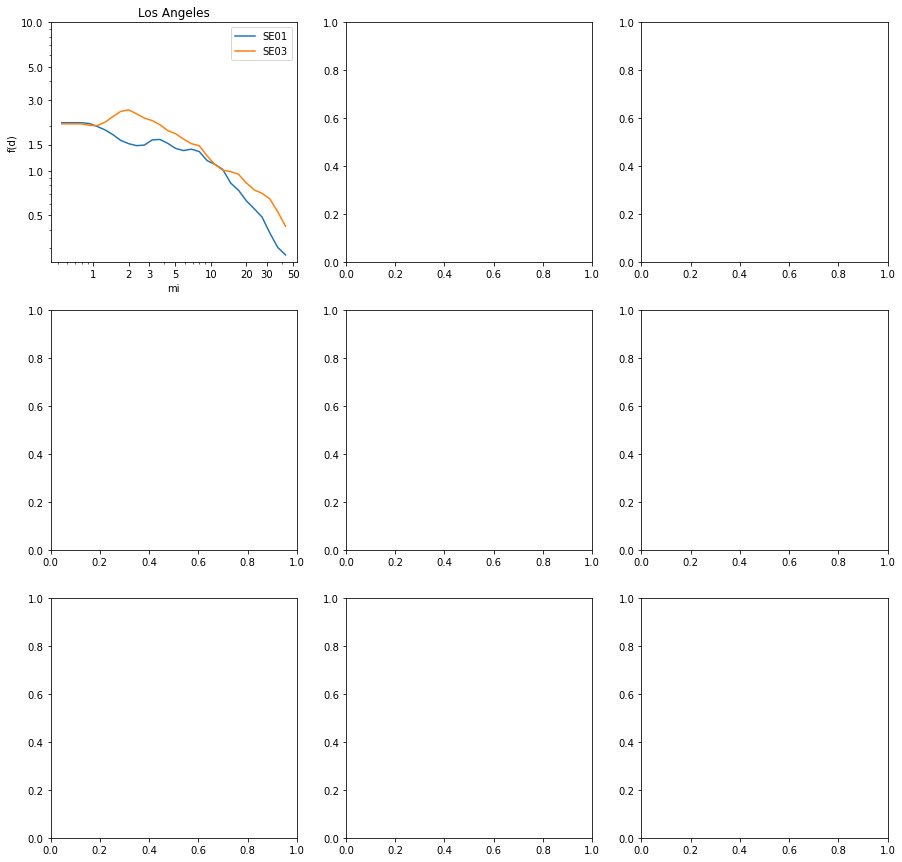

In [13]:


fig,ax = plt.subplots(3,3,figsize=(15,15))
i= 0
for city in cities[1:2]:

    df = pd.DataFrame({'bin':Distfd1[city].keys(),'fd':Distfd1[city].values()})
    df = df.sort_values(by='bin')
    df['bin+1'] = df['bin'].shift(1)
    df['bin+1'].fillna(df['bin'][0],inplace=True)
    df['fd+1'] = df['fd'].shift(1)
    df['fd+1'].fillna(df['fd'][0],inplace=True)
    df['fdsmooth'] = (df['fd']+df['fd+1'])/2
    df['binsmooth'] = (df['bin']+df['bin+1'])/2
    ax[i//3,i%3].plot(df['binsmooth'],df['fdsmooth'],label='SE01')

    df = pd.DataFrame({'bin':Distfd3[city].keys(),'fd':Distfd3[city].values()})
    df['bin+1'] = df['bin'].shift(1)
    df['bin+1'].fillna(df['bin'][0],inplace=True)
    df['fd+1'] = df['fd'].shift(1)
    df['fd+1'].fillna(df['fd'][0],inplace=True)
    df['fdsmooth'] = (df['fd']+df['fd+1'])/2
    df['binsmooth'] = (df['bin']+df['bin+1'])/2
    df = df.sort_values(by='bin')
    ax[i//3,i%3].plot(df['binsmooth'],df['fdsmooth'],label='SE03')

    ax[i//3,i%3].set_title(city)
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_yscale('log')
    ax[i//3,i%3].set_xscale('log')
    ax[i//3,i%3].set_yticks([0.5, 1, 1.5, 3, 5, 10])
    ax[i//3,i%3].set_xticks([1, 2, 3, 5, 10, 20, 30, 50])
    ax[i//3,i%3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//3,i%3].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//3,i%3].set_ylabel('f(d)')
    ax[i//3,i%3].set_xlabel('mi')
    i += 1

# plt.savefig('curve.png')